# Convolution Neural Networks: CIFAR-10 Dataset
### Please let me know if you found any errors, Email me at qiang.sun@utoronto.ca
#### I strongly encourage to buy Google Colab Pro.

This assignment uses the classic [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is a labeled subset of the 80 million tiny images dataset. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

In [ ]:
###checking if we are getting GPU in colab
###if not, Runtime → Change runtime type and Set Hardware accelerator to GPU
!nvidia-smi

Sun Feb  1 03:56:23 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             34W /   70W |     712MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

#We are gonna to define all the functions so that we can train the model better later
###Data Loader and evaluation [Fill in where you have raise NotImplementedError("Fill me in")]
---




In [ ]:
### data loaders (CIFAR-10) ####
def get_cifar10_loaders(batch_size=128, num_workers=2, val_size=5000, seed=42):
    # CIFAR-10 mean/std (common)
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    # Data augmentation ONLY for training
    train_tfms = T.Compose([

        ### please augment the dataset using Random Crop and Horizontal Flip; please check torchvision.transforms
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(p=0.5),
        # raise NotImplementedError("Fill me in!")

        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    # No augmentation for val/test
    eval_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    # Load the official CIFAR10 train set twice with different transforms
    full_train_for_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=train_tfms
    )
    full_train_for_eval = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=eval_tfms
    )

    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=eval_tfms
    )

    # Split indices deterministically
    n_total = len(full_train_for_train)  # 50,000
    n_val = val_size
    n_train = n_total - n_val

    g = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(full_train_for_train, [n_train, n_val], generator=g)

    # IMPORTANT: val subset should use eval transforms (no augmentation)
    # So we re-create val subset with the same indices but using full_train_for_eval
    val_subset = torch.utils.data.Subset(full_train_for_eval, val_subset.indices)

    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return trainloader, valloader, testloader


###Model Eval
---

In [ ]:
###Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        # returns True if we should stop
        improved = val_loss < (self.best_loss - self.min_delta)
        if improved:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


###Eval
@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

##Train your model

*   Please fill in the blanks


In [ ]:
def train_with_early_stopping_adamw(
    model,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,
    weight_decay=1e-2,
    patience=3,
    save_path="best_cifar10_simplecnn.pt",
):
    criterion = nn.CrossEntropyLoss()

    # raise NotImplementedError("Fill me in for the optimizer!")
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    ###we will use adamW optimizer with learning rate and weight decay

    # raise NotImplementedError("Fill me in for the optimizer!")
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    ###we will Cosine Annealing Learning Rate; check torch.optim.lr_scheduler.CosineAnnealingLR

    early_stopper = EarlyStopping(patience=patience, min_delta=0.0)

    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        scheduler.step()

        train_loss = loss_sum / total
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, valloader, device, criterion)

        # Save best model by val loss
        if val_loss < early_stopper.best_loss:
            torch.save(model.state_dict(), save_path)

        best_val_acc = max(best_val_acc, val_acc)

        print(
            f"Epoch {epoch:3d}/{epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc*100:.2f}% | "
            f"val loss {val_loss:.4f} acc {val_acc*100:.2f}% | "
            f"best val acc {best_val_acc*100:.2f}%"
        )

        if early_stopper.step(val_loss):
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    # Load best weights
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()
    return model

### Visualize data

In [ ]:
###trainloader and testloader
trainloader, valloader, testloader = get_cifar10_loaders(
    batch_size=128,
    num_workers=2,
    val_size=5000,
    seed=42
)


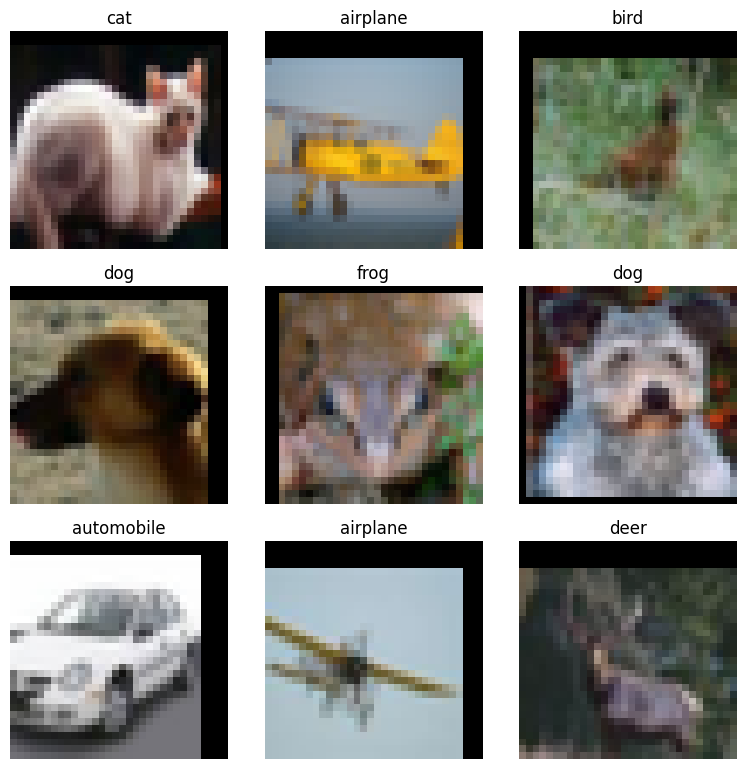

In [ ]:
# CIFAR-10 label names (0..9)
classes = ("airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

# If you used Normalize(mean,std) during training, use the same values here:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

def unnormalize(img):
    m = torch.tensor(mean).view(3, 1, 1)
    s = torch.tensor(std).view(3, 1, 1)
    return img * s + m

def show_batch_from_loader(loader, n=16):
    images, labels = next(iter(loader))   # images: (B,3,32,32), labels: (B,)
    images, labels = images[:n].cpu(), labels[:n].cpu()

    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 2.6, rows * 2.6))
    for i in range(n):
        img = unnormalize(images[i]).clamp(0, 1)          # back to [0,1]
        img = img.permute(1, 2, 0).numpy()                # (H,W,C)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(classes[int(labels[i])])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_batch_from_loader(trainloader, n=9)

# Build Model 1
#### Build a CNN model
#### Architecture: from bottom (input) to top (output)

  (input)

	•	Conv(3→32, 3×3) + BN + ReLU     ###check nn.BatchNorm2d
	•	Conv(32→32, 3×3) + BN + ReLU
	•	MaxPool(2) + Dropout(0.25)
	•	Conv(32→64, 3×3) + BN + ReLU
	•	Conv(64→64, 3×3) + BN + ReLU
	•	MaxPool(2) + Dropout(0.25)
	•	Conv(64→128, 3×3) + BN + ReLU
	•	GlobalAvgPool                   ###check nn.AdaptiveAvgPool2d
	•	Linear(128→10)                  ###features to classes

  (softmax + output)
  

#### We will use torch.optim.AdamW with lr=3e-4, weight_decay=1e-2

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        self.features = nn.Sequential(
            # Conv(3→32, 3×3) + BN + ReLU
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Conv(32→32, 3×3) + BN + ReLU
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # MaxPool(2) + Dropout(0.25)
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            # Conv(32→64, 3×3) + BN + ReLU
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Conv(64→64, 3×3) + BN + ReLU
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # MaxPool(2) + Dropout(0.25)
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),

            # Conv(64→128, 3×3) + BN + ReLU
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # GlobalAvgPool
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        # Linear(128→10)
        self.classifier = nn.Linear(128, num_classes)

        # raise NotImplementedError("Fill me in for the optimizer!")

    def forward(self, x):
        x = self.features(x)          # (B, 128, 1, 1)
        x = torch.flatten(x, 1)       # (B, 128)
        x = self.classifier(x)        # (B, 10)
        return x


        # raise NotImplementedError("Fill me in for the optimizer!")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes = 10).to(device)

### Inspect the model first: Summarize the model first to see we build the right one

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
summary(model, input_size=(1, 3, 32, 32))  # CIFAR-10: 3x32x32

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           864
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 32, 32]           64
│    └─ReLU: 2-6                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 32, 16, 16]           --
│    └─Dropout: 2-8                      [1, 32, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 64, 16, 16]           18,432
│    └─BatchNorm2d: 2-10                 [1, 64, 16, 16]           128
│    └─ReLU: 2-11                        [1, 64, 16, 16]           --
│    └

In [ ]:
# Run the model
# Use patience = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_train = train_with_early_stopping_adamw(
    model,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,   ### 3e-4 usually works well
    weight_decay=1e-2,  ###1e-2 usually works well
    patience=3,
    save_path="best_cifar10_simplecnn_adamw.pt"
)

Epoch   1/50 | train loss 1.6688 acc 39.18% | val loss 1.3903 acc 49.88% | best val acc 49.88%
Epoch   2/50 | train loss 1.3178 acc 52.88% | val loss 1.2355 acc 55.14% | best val acc 55.14%
Epoch   3/50 | train loss 1.1653 acc 58.55% | val loss 1.0878 acc 61.24% | best val acc 61.24%
Epoch   4/50 | train loss 1.0827 acc 61.50% | val loss 1.0305 acc 63.02% | best val acc 63.02%
Epoch   5/50 | train loss 1.0201 acc 63.94% | val loss 0.9821 acc 65.04% | best val acc 65.04%
Epoch   6/50 | train loss 0.9800 acc 65.14% | val loss 0.9494 acc 66.52% | best val acc 66.52%
Epoch   7/50 | train loss 0.9369 acc 66.99% | val loss 0.9119 acc 67.04% | best val acc 67.04%
Epoch   8/50 | train loss 0.9059 acc 67.93% | val loss 0.8799 acc 68.84% | best val acc 68.84%
Epoch   9/50 | train loss 0.8755 acc 69.17% | val loss 1.0323 acc 64.46% | best val acc 68.84%
Epoch  10/50 | train loss 0.8530 acc 70.12% | val loss 0.8613 acc 70.18% | best val acc 70.18%
Epoch  11/50 | train loss 0.8295 acc 70.88% | val 

### Final test evaluation
###What is the test_loss and test accuracy

In [ ]:
# raise NotImplementedError("Fill me in for the optimizer!")
test_loss, test_acc = evaluate(model, testloader, device, nn.CrossEntropyLoss())
print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

FINAL TEST | loss 0.6994 acc 76.29%


#Question: What if we do not have the data augmentation?

[Summarize your findings here]

If data augmentation is not used, the model tends to overfit the training data more easily because it only sees each CIFAR-10 image in a fixed position and orientation. This usually leads to higher training accuracy but lower validation and test accuracy, as the learned features are less robust to small translations and horizontal flips that naturally occur in unseen data. Consequently, the generalization gap between training and validation performance increases, and validation accuracy often saturates earlier compared to training with data augmentation.


#Build Model 2: VGG-style model and repeat the above analysis for model 1
###Architecture

    Input: (N, 3, 32, 32)

    Block 1 (channels 64)
      1.	Conv3×3, 3→64, pad=1 → (N, 64, 32, 32)
      2.	BN(64) + ReLU
      3.	Conv3×3, 64→64, pad=1 → (N, 64, 32, 32)
      4.	BN(64) + ReLU
      5.	MaxPool2×2 → (N, 64, 16, 16)
      6.	Dropout(p=0.25)

    Block 2 (channels 128)
      7.	Conv3×3, 64→128, pad=1 → (N, 128, 16, 16)
      8.	BN(128) + ReLU
      9.	Conv3×3, 128→128, pad=1 → (N, 128, 16, 16)
      10.	BN(128) + ReLU
      11.	MaxPool2×2 → (N, 128, 8, 8)
      12.	Dropout(p=0.25)

    Block 3 (channels 256)
      13.	Conv3×3, 128→256, pad=1 → (N, 256, 8, 8)
      14.	BN(256) + ReLU
      15.	Conv3×3, 256→256, pad=1 → (N, 256, 8, 8)
      16.	BN(256) + ReLU
      17.	MaxPool2×2 → (N, 256, 4, 4)
      18.	Dropout(p=0.25)

    Head
      19.	AdaptiveAvgPool2d(1) → (N, 256, 1, 1)
      20.	Flatten → (N, 256)
      21.	Linear 256→10 → (N, 10)

    Softmax + Output

In [ ]:
class VGGSmallCIFAR(nn.Module):
    """
    VGG-style network for CIFAR-10:
      (64x2) -> pool -> (128x2) -> pool -> (256x2) -> pool -> GAP -> FC
    Input:  (N,3,32,32)
    Output: (N,10)
    """
    def __init__(self, num_classes=10, dropout=0.25):
        super().__init__()
        self.features = nn.Sequential(
        # Block 1 (channels 64)
          nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),   # (N,64,32,32)
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),

          nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),  # (N,64,32,32)
          nn.BatchNorm2d(64),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(kernel_size=2, stride=2),                    # (N,64,16,16)
          nn.Dropout(p=dropout),

        # Block 2 (channels 128)
          nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False), # (N,128,16,16)
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),# (N,128,16,16)
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(kernel_size=2, stride=2),                    # (N,128,8,8)
          nn.Dropout(p=dropout),

        # Block 3 (channels 256)
          nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),# (N,256,8,8)
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),

          nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),# (N,256,8,8)
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),

          nn.MaxPool2d(kernel_size=2, stride=2),                    # (N,256,4,4)
          nn.Dropout(p=dropout),

        # Head part inside features
          nn.AdaptiveAvgPool2d((1, 1)),                             # (N,256,1,1)
        )

        self.classifier = nn.Linear(256, num_classes)               # (N,10)
        # raise NotImplementedError("Fill me in for the optimizer!")

    def forward(self, x):

        x = self.features(x)          # (N,256,1,1)
        x = torch.flatten(x, 1)       # (N,256)
        x = self.classifier(x)        # (N,10)
        return x
        # raise NotImplementedError("Fill me in for the optimizer!")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = VGGSmallCIFAR(num_classes=10).to(device)

summary(model2, input_size=(1, 3, 32, 32))

# x = torch.randn(4, 3, 32, 32).to(device)
# y = model(x)
# print("Output shape:", y.shape)  # should be torch.Size([4, 10])

Layer (type:depth-idx)                   Output Shape              Param #
VGGSmallCIFAR                            [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,864
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Dropout: 2-8                      [1, 64, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 128, 16, 16]          73,728
│    └─BatchNorm2d: 2-10                 [1, 128, 16, 16]          256
│    └─ReLU: 2-11                        [1, 128, 16, 16]          --
│

In [ ]:
model2_train = train_with_early_stopping_adamw(
    model2,
    trainloader,
    valloader,
    device,
    epochs=50,
    lr=3e-4,              # lr = 3e-4
    weight_decay=1e-2,    # patience =
    patience=3,
    save_path="best_vggsmall_cifar10_adamw.pt"
)

# Final test verification
test_loss, test_acc = evaluate(model2_train, testloader, device, nn.CrossEntropyLoss())
print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

Epoch   1/50 | train loss 0.3014 acc 89.42% | val loss 0.3898 acc 87.06% | best val acc 87.06%
Epoch   2/50 | train loss 0.3066 acc 89.24% | val loss 0.3907 acc 87.12% | best val acc 87.12%
Epoch   3/50 | train loss 0.2969 acc 89.63% | val loss 0.3807 acc 87.70% | best val acc 87.70%
Epoch   4/50 | train loss 0.2927 acc 89.66% | val loss 0.3834 acc 87.52% | best val acc 87.70%
Epoch   5/50 | train loss 0.2892 acc 89.97% | val loss 0.3780 acc 87.82% | best val acc 87.82%
Epoch   6/50 | train loss 0.2786 acc 90.15% | val loss 0.3721 acc 87.18% | best val acc 87.82%
Epoch   7/50 | train loss 0.2727 acc 90.36% | val loss 0.3826 acc 87.20% | best val acc 87.82%
Epoch   8/50 | train loss 0.2692 acc 90.44% | val loss 0.3749 acc 87.82% | best val acc 87.82%
Epoch   9/50 | train loss 0.2616 acc 90.74% | val loss 0.3897 acc 87.28% | best val acc 87.82%
Early stopping triggered at epoch 9.
FINAL TEST | loss 0.3972 acc 87.30%


#Build Model 3: Resnet
#### For Resnet, please refer to the paper: https://arxiv.org/abs/1512.03385

####Architecture
    Overall structure (CIFAR ResNet)

    Input: (N, 3, 32, 32)

    Stem
      1.	Conv 3×3, 3 → 16, stride 1, pad 1
      2.	BatchNorm(16)
      3.	ReLU
    Output: (N, 16, 32, 32)

    ⸻

    Residual stages (BasicBlock)

    Each BasicBlock is:
      •	Conv 3×3 (stride = s), BN, ReLU
      •	Conv 3×3 (stride = 1), BN
      •	Add shortcut (identity if shape matches, else 1×1 conv + BN)
      •	ReLU

    Stage 1: width 16, spatial 32×32
      •	3 BasicBlocks (for ResNet-20)
      •	First block stride=1 (no downsampling)
    Output stays: (N, 16, 32, 32)

    Stage 2: width 32, spatial 16×16
      •	3 BasicBlocks
      •	First block uses stride=2 → downsamples 32×32 → 16×16
      •	Shortcut uses 1×1 conv stride=2 (because channels/spatial change)
    Output: (N, 32, 16, 16)

    Stage 3: width 64, spatial 8×8
      •	3 BasicBlocks
      •	First block uses stride=2 → downsamples 16×16 → 8×8
      •	Shortcut uses 1×1 conv stride=2
    Output: (N, 64, 8, 8)

    ⸻

    Head
      •	Global Average Pool (AdaptiveAvgPool2d(1)): (N, 64, 1, 1)
      •	Flatten → (N, 64)
      •	Linear 64 → 10 → (N, 10)


####Please repeat your analysis and then summarize your findings

In [ ]:
###THe BasicBlock is complete
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes: int, planes: int, stride: int = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)

        # Projection shortcut if shape changes (stride or channels)
        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        out = F.relu(out, inplace=True)
        return out



####Please fill in the blanks in this class
class ResNetCIFAR(nn.Module):
    """
    CIFAR-style ResNet:
      stem: 3x3 conv, 16ch
      stage1: 16ch blocks, stride 1
      stage2: 32ch blocks, stride 2
      stage3: 64ch blocks, stride 2
      GAP + FC
    """
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 16

        # raise NotImplementedError("Fill me in for the optimizer!")
        # Stem
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(16)

        # Residual stages
        self.layer1 = self._make_layer(block, planes=16, n_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, planes=32, n_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, planes=64, n_blocks=num_blocks[2], stride=2)

        # Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(64 * block.expansion, num_classes)


    ####helper: _make_layer for layers 1, 2, 3
    def _make_layer(self, block, planes, n_blocks, stride):
        strides = [stride] + [1] * (n_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, stride=s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # raise NotImplementedError("Fill me in for the optimizer!")
        # Stem
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)  # (N,16,32,32)

        # Residual stages
        out = self.layer1(out)  # (N,16,32,32)
        out = self.layer2(out)  # (N,32,16,16)
        out = self.layer3(out)  # (N,64,8,8)

        # Head
        out = self.avgpool(out)            # (N,64,1,1)
        out = torch.flatten(out, 1)        # (N,64)
        out = self.fc(out)                 # (N,10)
        return out


####main restnet
def resnet20_cifar(num_classes=10):
    # 6n+2 layers, n=3 -> 20
    return ResNetCIFAR(BasicBlock, [3, 3, 3], num_classes=num_classes)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = resnet20_cifar(num_classes=10).to(device)

summary(model3, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetCIFAR                              [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           432
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─Sequential: 1-3                        [1, 16, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-2             [1, 16, 32, 32]           32
│    │    └─Conv2d: 3-3                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-4             [1, 16, 32, 32]           32
│    │    └─Identity: 3-5                [1, 16, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           2,304
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    

In [ ]:
model3_train = train_with_early_stopping_adamw(
    model3,
    trainloader,
    valloader,
    device,
    epochs=50,  ###epochs = 50
    lr=3e-4,
    weight_decay=1e-2,  ###
    patience=3,   ###
    save_path="best_resnet20_cifar10_adamw.pt"
)

Epoch   1/50 | train loss 1.5788 acc 41.69% | val loss 1.3733 acc 49.16% | best val acc 49.16%
Epoch   2/50 | train loss 1.2068 acc 56.56% | val loss 1.1494 acc 59.00% | best val acc 59.00%
Epoch   3/50 | train loss 1.0300 acc 63.28% | val loss 0.9753 acc 65.24% | best val acc 65.24%
Epoch   4/50 | train loss 0.9248 acc 67.30% | val loss 1.0583 acc 63.14% | best val acc 65.24%
Epoch   5/50 | train loss 0.8315 acc 70.91% | val loss 1.0471 acc 65.74% | best val acc 65.74%
Epoch   6/50 | train loss 0.7583 acc 73.61% | val loss 0.8453 acc 70.76% | best val acc 70.76%
Epoch   7/50 | train loss 0.7053 acc 75.49% | val loss 0.7009 acc 75.34% | best val acc 75.34%
Epoch   8/50 | train loss 0.6587 acc 76.95% | val loss 0.7453 acc 74.26% | best val acc 75.34%
Epoch   9/50 | train loss 0.6295 acc 78.25% | val loss 0.6707 acc 76.92% | best val acc 76.92%
Epoch  10/50 | train loss 0.5947 acc 79.50% | val loss 0.6040 acc 78.92% | best val acc 78.92%
Epoch  11/50 | train loss 0.5669 acc 80.44% | val 

In [ ]:
# raise NotImplementedError("Fill me in for the optimizer!")
test_loss, test_acc = evaluate(model3_train, testloader, device, nn.CrossEntropyLoss())
print(f"FINAL TEST | loss {test_loss:.4f} acc {test_acc*100:.2f}%")

FINAL TEST | loss 0.5461 acc 81.34%


#Summarize your findings here

[Fill in here]
Model 2 outperformed with test_acc of 87.3% because it has higher capacity (wider feature maps) while BN+dropout+augmentation controlled overfitting; ResNet-20 benefited from residual optimization but was narrower, with 81.34% test accuracy; Model 1 had the lowest capacity and thus the weakest performance, with test_acc of 76.29%.